In [2]:
import numpy as np 
import matplotlib.pyplot as plt

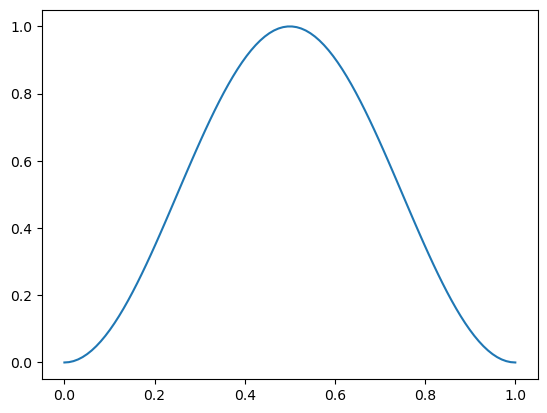

In [184]:
# define nice cosine function to evolve 
def f(x):
    return -0.5 * np.cos(2 * np.pi * x) + .5

xs = np.linspace(0, 1, 100)
ys = f(xs)
# plot 
plt.plot(xs, ys)

In [185]:
# build numerical derivative
y_next = np.zeros(ys.shape)
dt = 0.01
dx = 1/ len(xs)
for i in range(1, len(ys)):
    y_next[i] = (1 - dt / dx) * ys[i] + dt / dx * ys[i-1]
y_next[0] = y_next[-1] # boundary conditions


In [211]:
def num_step(ys, dt, nsteps = 1):
    """integrate function forward in time with specified time step, dt, and a number of steps, nsteps."""
    nsteps -=1 
    y_next = np.zeros(ys.shape)
    dx = 1/ len(xs)
    for i in range(1, len(ys)):
        y_next[i] = (1 - dt / dx) * ys[i] + dt / dx * ys[i-1]
    y_next[0] = y_next[-1] # boundary conditions
    # recursive call for nsteps
    if nsteps > 0:
        return num_step(y_next, dt, nsteps)
    else:
        return y_next

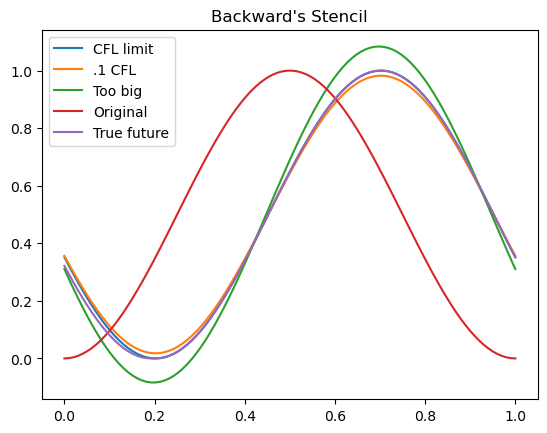

In [218]:
plt.plot(xs, num_step(ys, 0.01, 20), label="CFL limit")
plt.plot(xs, num_step(ys, 0.001, 200), label=".1 CFL")

plt.plot(xs, num_step(ys, 0.05, 4), label="Too big")

plt.plot(xs, ys, label = "Original")
plt.plot(xs, np.roll(ys, 20), label="True future")
plt.title("Backward's Stencil")
plt.legend()

In [215]:
print(max(num_step(ys, 0.01, 20)))
print(max(num_step(ys, 0.05, 4)))


0.9997482711915926
1.083773946116752


## Code specific example of ML stability 
For our linear update problem we have the following prediction step and data. Given pairs $\{(x_i, y_i)\}_{i=1}^N;\;x_i, y_i \in \mathbb{R}^M$ we define our prediction step
$$ y_i = Ax_i $$
where:
$$A = \begin{bmatrix}
b & a & 0 & \dotsb& 0 \\
0 & b & a & \dotsb &0\\
\vdots & \vdots & \vdots & \vdots \\
0 & \dotsb & 0  & b & a
\end{bmatrix} \in \mathbb{R}^{(M-1)\times M}$$
Here we note that we will ignore the loss of the first entry because since the domain repeats we'd otherwise double count the loss. For this problem let's minimize the L2 loss of the update rule 
\begin{align}
\min_{a,b} || y_i - Ax_i || \rightarrow \min_{a,b}& \sum_{i=1}^N \sum_{j=1}^M \big(y_{i,j}-(Ax_i)_j\big)^2 \\
\min_{a,b}& \sum_{i=1}^N \sum_{j=2}^M \left( y_j - bx_{j-1} - ax_j \right)^2
\end{align}
The second expression on the first row is not quite indexed correctly but should give the idea 

So $Ax$ for a given $x$ looks like
\begin{align}
\begin{bmatrix}
bx_1+ax_2 \\
bx_2+ax_3 \\
\vdots \\
bx_{M-1}+ax_M
\end{bmatrix} \in \mathbb{R}^{M-1}
\end{align}
noting again that $x_1=x_M$ 

As this is a least squares problem we expand the expression to develop an exact solution to the minimization problem, getting equations for $a,b$. We do so as follows 
\begin{align}
F &= \sum_{i=1}^N \sum_{j=2}^M \left( y_{i,j} - bx_{i,j-1} - ax_{i,j} \right)^2 \\
\frac{dF}{da} &= \sum_{i,j} \frac{d}{da} (y_{i,j}-bx_{i,j-1}-ax_{i,j})^2 \\
&= -\sum_{i,j} 2 (y_{i,j} - bx_{i,j-1}-ax_{i,j}) x_{i,j} \\
\frac{dF}{db} &= \sum_{i,j} \frac{d}{db} (y_{i,j}-bx_{i,j-1}-ax_j)^2 \\
&= -\sum_{i,j} 2 (y_{i,j} - bx_{i,j-1}-ax_{i,j}) x_{i, j-1}
\end{align}


To solve we set both derivatives to zero (noting the second derivatives are squared terms and so necessarily negative, ensuring we are at at maxima). Expanding yeilds the following sum of terms: 
\begin{align}
(b): 0 &= \sum_{i,j} y_{i,j}x_{i,j-1} - b\sum_{i,j} x_{i,j-1}^2 - a\sum_{i,j} x_{i,j}x_{i,j-1} \\
(a): 0 &= \sum_{i,j}y_{i,j}x_{i,j} - b \sum_{i,j} x_{i,j-1}x_{i,j} - a \sum x_{i,j}^2
\end{align}
This is now a linear system we can solve. To simplify, we introduce the following abbreviations (A is abuse of notation - fix!): 
\begin{align}
A &= \sum_{i,j} x_{i,j-1}y_{i,j} \\
B &= \sum_{i,j} x_{i,j} x_{i,j-1} \\
C &= \sum_{i,j} x_{i,j-1}^2 \\
D &= \sum_{i,j} x_{i,j}y_{i,j} \\
E &= \sum_{i,j} x_{i,j}^2
\end{align}

airplane algebra mess (checks with board work)

\begin{align}
0 &= A - b C - a B \\
a &= (A-bC)/B \\
0 &= D - b B - a E \\
b &= (D-aE)/B \\

0 &= D - bB - (A-bC)E/B \\
&= BD - bB^2 -AE + bCE \\
&= BD-AE - b(B^2-CE) \\
\implies b &= \boxed{\frac{BD-AE}{B^2-CE}} \\

0 &= A- (D-aE)C/B - aB \\
&= AB - DC + aCE - aB^2 \\
&= AB - DC -a (B^2 - CE) \\
a &= \boxed{\frac{AB - DC}{B^2-CE}} \\

\end{align}

Thus our optimization becomes:

\begin{align}
a &= \frac{\sum_{i,j} x_{i,j-1}y_{i,j} \sum_{i,j} x_{i,j} x_{i,j-1} - \sum_{i,j} x_{i,j}y_{i,j} \sum_{i,j} x_{i,j-1}^2}{\left(\sum_{i,j} x_{i,j} x_{i,j-1} \right)^2 - \sum_{i,j} x_{i,j-1}^2 \sum_{i,j} x_{i,j}^2} \\
b &= \frac{\sum_{i,j} x_{i,j} x_{i,j-1} \sum_{i,j} x_{i,j}y_{i,j} - \sum_{i,j} x_{i,j-1}y_{i,j} \sum_{i,j} x_{i,j}^2}{\left(\sum_{i,j} x_{i,j} x_{i,j-1} \right)^2 - \sum_{i,j} x_{i,j-1}^2 \sum_{i,j} x_{i,j}^2}
\end{align}

# Generate test data

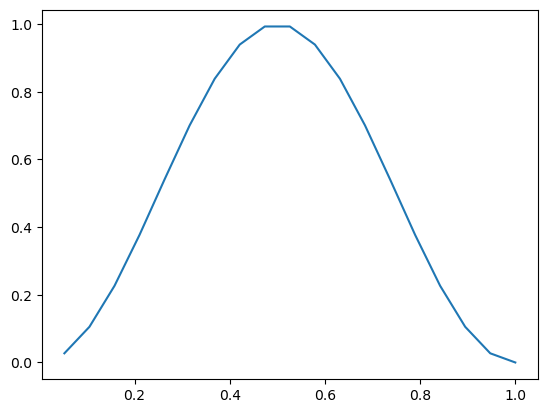

In [220]:
# define nice cosine function to evolve 
dx = 0.05
def f(x):
    return -0.5 * np.cos(2 * np.pi * x) + .5

xs = np.linspace(0, 1, int(1/dx))[1:]
ys = f(xs)
# plot 
plt.plot(xs, ys)

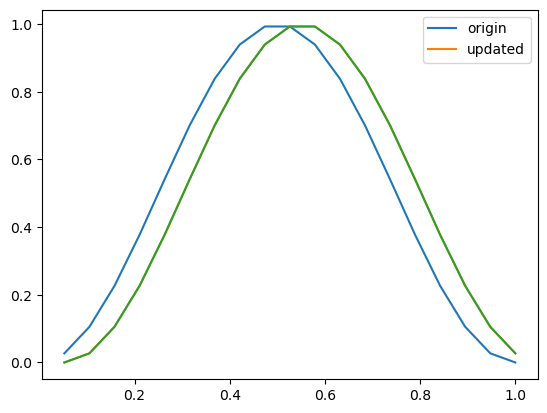

In [222]:
test = np.ones(len(xs))
test[1:] = ys[0:-1]
test[0] = ys[-1]
plt.plot(xs, ys, label = "origin")
plt.plot(xs, test, label = "updated")
plt.plot(xs, np.roll(ys, 1))
plt.legend()

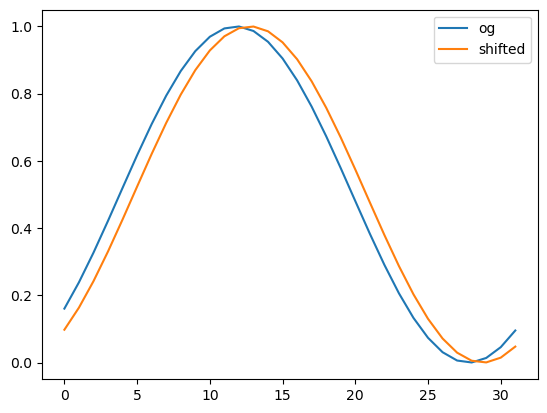

In [76]:
def gen_pair(offset = 0, dx = 0.05):
    sampling = np.linspace(0+offset, 1+offset, int(1/dx))[1:] % 1
    xs = f(sampling)
    ys = f(sampling - dx)
    return xs, ys 

tx, ty = gen_pair(.1, .03)

plt.plot(tx, label="og")
plt.plot(ty, label='shifted')
plt.legend()

In [164]:
# generate samples of training data 
num_samples = 100
dx = 0.05
rand_offsets = np.random.rand(num_samples)
x_ar, y_ar = [], []
for offset in rand_offsets:
    x, y = gen_pair(offset, dx = dx)
    x_ar.append(x) 
    y_ar.append(y)

x_ar = np.array(x_ar)
y_ar = np.array(y_ar)

\begin{align}
A &= \sum_{i,j} x_{i,j-1}y_{i,j} \\
B &= \sum_{i,j} x_{i,j} x_{i,j-1} \\
C &= \sum_{i,j} x_{i,j-1}^2 \\
D &= \sum_{i,j} x_{i,j}y_{i,j} \\
E &= \sum_{i,j} x_{i,j}^2
\end{align}

In [228]:
# define matrix shift function
def shift_x(x_ar):
    x_ar_shifted = np.zeros(x_ar.shape)

    x_ar_shifted[:, 1:] = x_ar[:, 0:-1]
    x_ar_shifted[:, 0] = x_ar[:, -1]
    return x_ar_shifted
x_ar_m1 = shift_x(x_ar)

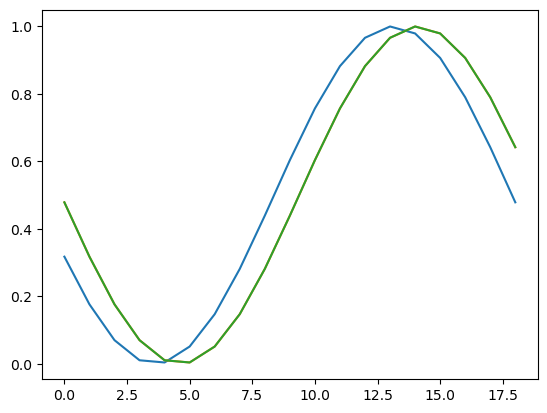

In [237]:
plt.plot(x_ar[0])
plt.plot(x_ar_m1[0])
plt.plot(np.roll(x_ar[0], 1))

In [166]:
# define terms 
E = np.sum(x_ar **2, axis=(0,1))
C=E
D = np.sum(x_ar * y_ar, axis=(0,1))
A = np.sum(shift_x(x_ar) * y_ar, axis=(0,1))
B = np.sum(shift_x(x_ar) * x_ar, axis = (0,1))

\begin{align}
a &= \boxed{\frac{AB - DC}{B^2-CE}} \\
b &= \boxed{\frac{BD-AE}{B^2-CE}}
\end{align}

In [167]:
a = ( A * B - D * C ) / ( B**2 - C * E )
b = ( B * D - A * C ) / ( B**2 - C * E ) 
print(a,b)

0.05003868679698027 0.9508194928912905


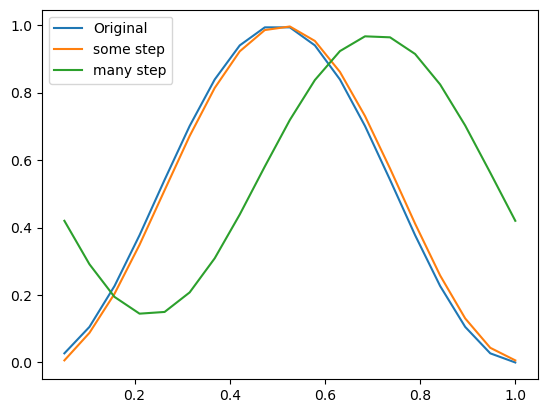

In [181]:
# compare long-term stability to numerical method
def step_trained_ml(ys, a, b, nsteps = 1):
    """integrate function forward in time with specified time step, dt, and a number of steps, nsteps."""
    nsteps -=1 
    y_next = np.zeros(ys.shape)
    for i in range(1, len(ys)):
        y_next[i] = b * ys[i] + a * ys[i-1]
    y_next[0] = y_next[-1] # boundary conditions
    # recursive call for nsteps
    if nsteps > 0:
        return step_trained_ml(y_next, a, b, nsteps)
    else:
        return y_next
    

plt.plot(xs, ys, label = "Original")
plt.plot(xs, step_trained_ml(ys, a, b, nsteps = 4), label="some step")
plt.plot(xs, step_trained_ml(ys, a, b, nsteps = 80), label="many step")

plt.legend()

array([0.02709138, 0.10542975, 0.22652592, 0.37725726, 0.54128967,
       0.70084771, 0.83864079, 0.93973688, 0.99318065, 0.99318065,
       0.93973688, 0.83864079, 0.70084771, 0.54128967, 0.37725726,
       0.22652592, 0.10542975, 0.02709138, 0.        ])